# Data Science Aplicada à Área de Saúde


## Extração de Relação entre Termos Médicos em dados Clínicos

## por Antonildo Santos


O objetivo deste trabalho é analisar um conjunto de dados de relações entre termos médicos em artigos PubMed, para extração de relação através do Processamento de Linguagem Natural.


## Introdução

A documentação de eventos clínicos são normalmente apresentados em formato de texto livre, pois trata-se de um método mais natural e que facilita a comunicação entre as equipes de saúde. A extração de informações clínicas de texto, tem sido um dos fatores críticos para o uso de dados do Prontuário Eletrônico do Paciente (PEP) como ferramenta de apoio a tomada de decisão clínica. Através do Processamento de Linguagem Natural (PLN) podemos extrair automaticamente conceitos, entidades e eventos, bem como suas relações e atributos associados de texto livre e assim encontrar padrões que definem restrições lexicais, sintáticas e semânticas. Esse processo geralmente envolve uma ou mais das seguintes subtarefas: conceito ou reconhecimento de entidade nomeada que identifica menções de conceito ou nomes de entidade a partir do texto (por exemplo, nomes de pessoas ou localizações), resolução de co-referência que associa menções ou nomes que se referem aos mesmos entidade, e extração de relação que identifica relações entre conceitos, entidades e atributos (por exemplo, afiliação pessoal e localização da organização). 


Neste projeto utilizei o conjunto de dados [Extração de informações médicas](https://appen.com/datasets/medical-sentence-summary-and-relation-extraction/) de relações entre termos médicos em artigos PubMed, para extração de relação e tarefas de processamento de linguagem natural relacionadas.

## Sobre o conjunto de dados

Este conjunto de dados contém 3.984 sentenças médicas extraídas dos resumos do PubMed e as relações entre termos médicos distintos que foram anotadas. Os dados concentra-se principalmente nas relações de “tratar” e “causar”, com 1.043 sentenças contendo relações de tratamento e 1.787 contendo relações causais. Os dados de entrada para este trabalho são frases de publicações médicas, relações médicas e um par de termos-chave dessa frase.
    
Um exemplo de sentença marcada com 'causa':

In [1]:
from IPython.display import Image
Image(url = '.\Imagens\Sentenças.png')

Usaremos a seguinte estratégia:

1. Análise exploratória dos dados
2. Tratamento das informações disponibilizadas no Dataset
3. Extrair os dados de todas as  sentenças e aprender as word embeddings.
4. Preparar os dados para os modelos de treinamento e avaliação doc2Vec
5. Contruir o vocabulário através de um modelo doc2vec - Distributed Bag of Words (DBOW)
6. Aplicar um modelo de Regressão Logística para classificação das sentenças
7. Avaliar a performance do modelo

In [184]:
import pandas as pd
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import collections
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_score, recall_score, roc_auc_score 
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [185]:
# Carregando o Dataset
train = pd.read_csv('.\\Dados\\train.csv', encoding='latin-1')
test = pd.read_csv('.\\Dados\\test.csv', encoding='latin-1')

### Explorando os dados

In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13340 entries, 0 to 13339
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _unit_id        13340 non-null  int64  
 1   _created_at     13340 non-null  object 
 2   _canary         7337 non-null   object 
 3   _id             13340 non-null  object 
 4   _started_at     13340 non-null  object 
 5   _channel        13340 non-null  object 
 6   _trust          13340 non-null  float64
 7   _worker_id      13340 non-null  int64  
 8   _country        13340 non-null  object 
 9   _region         11873 non-null  object 
 10  _city           11795 non-null  object 
 11  _ip             13340 non-null  object 
 12  direction       13340 non-null  object 
 13  b1              13340 non-null  int64  
 14  b2              13340 non-null  int64  
 15  direction_gold  0 non-null      float64
 16  e1              13340 non-null  int64  
 17  e2              13340 non-null 

In [187]:
train.head(10)

,_unit_id,_created_at,_canary,_id,_started_at,_channel,_trust,_worker_id,_country,_region,...,direction_gold,e1,e2,relation,relex_relcos,sent_id,sentence,term1,term2,twrex
0,502808352,7/13/2014 13:48:35,NaN,1321892767,7/13/2014 13:48:14,clixsense,0.9167,27871219,NLD,07,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
1,502808352,7/13/2014 13:51:12,NaN,1321894040,7/13/2014 13:51:07,neodev,0.8333,17610000,GBR,I2,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
2,502808352,7/13/2014 16:24:57,NaN,1321961909,7/13/2014 16:24:35,instagc,0.6639,25990856,USA,NV,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
3,502808352,7/13/2014 16:33:49,NaN,1321965723,7/13/2014 16:33:31,elite,0.3923,28276268,USA,CA,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
4,502808352,7/13/2014 16:47:27,NaN,1321970904,7/13/2014 16:47:06,neodev,0.6552,27597779,CAN,AB,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
5,502808352,7/13/2014 16:56:13,NaN,1321973849,7/13/2014 16:55:37,clixsense,0.6639,28037714,GBR,I4,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
6,502808352,7/13/2014 17:14:41,NaN,1321979856,7/13/2014 17:14:06,prodege,0.6151,2422962,USA,IA,...,NaN,69,142,treats,1.00000,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE,RO-may_treat
7,502808354,7/13/2014 13:45:15,NaN,1321891302,7/13/2014 13:44:25,clixsense,0.9167,27871219,NLD,07,...,NaN,187,217,diagnosed by,0.53033,906321-FS1-13,Diagnosis specific malignancies available for ...,OSTEOSARCOMA,RETINOBLASTOMA,RO-has_manifestation
8,502808354,7/13/2014 13:50:45,NaN,1321893871,7/13/2014 13:50:40,neodev,0.8333,17610000,GBR,I2,...,NaN,187,217,diagnosed by,0.53033,906321-FS1-13,Diagnosis specific malignancies available for ...,OSTEOSARCOMA,RETINOBLASTOMA,RO-has_manifestation
9,502808354,7/13/2014 14:07:58,NaN,1321902037,7/13/2014 14:07:28,prodege,0.9444,23977248,GBR,B5,...,NaN,187,217,diagnosed by,0.53033,906321-FS1-13,Diagnosis specific malignancies available for ...,OSTEOSARCOMA,RETINOBLASTOMA,RO-has_manifestation


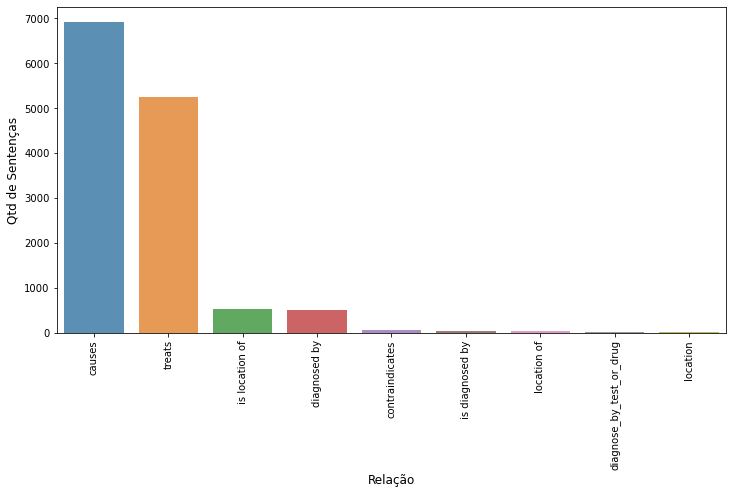

In [188]:
relacao = train['relation'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(relacao.index, relacao.values, alpha=0.8)
plt.ylabel('Qtd de Sentenças', fontsize=12)
plt.xlabel('Relação', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Podemos observar que as anotações concentram-se principalmente nas relações de “tratar” e “causar”

Os anotadores humanos receberam dois termos diferentes (como por exemplo "Demência por corpos de Lewy" e "Alucinações visuais bem formadas") e foram solicitados a marcar a relação entre esses termos (neste caso, "Demência por corpos de Lewy causa Alucinações visuais formadas). Cada artigo foi avalidado por sete profissionais diferentes,  onde foi estabelecido uma confiança para cada marcação. 

In [189]:
from matplotlib.ticker import StrMethodFormatter

In [190]:
train['sentence_len'] = train['sentence'].astype(str).apply(len)
train['word_count'] = train['sentence'].apply(lambda x: len(str(x).split()))

### Visualizando a distribuição do comprimento do texto das Sentenças 

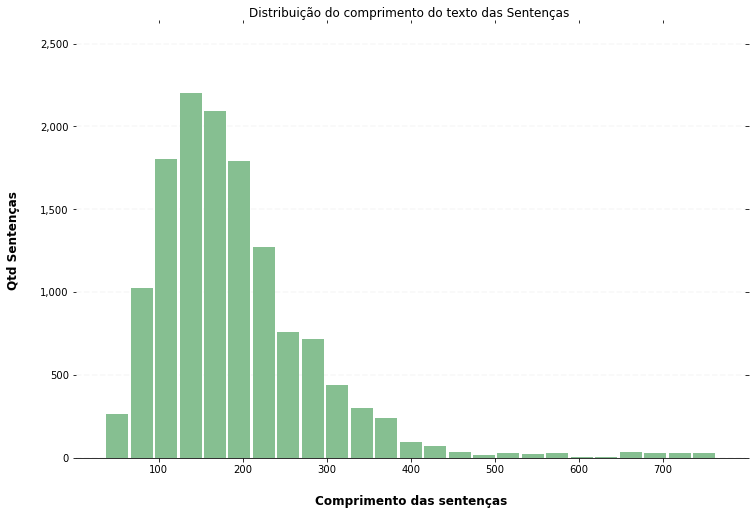

In [191]:
ax = train.hist(column='sentence_len', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # title
    x.set_title("Distribuição do comprimento do texto das Sentenças ")

    # Set x-axis label
    x.set_xlabel("Comprimento das sentenças", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Qtd Sentenças", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

### Visualizando a distribuição da contagem de palavras das sengtenças

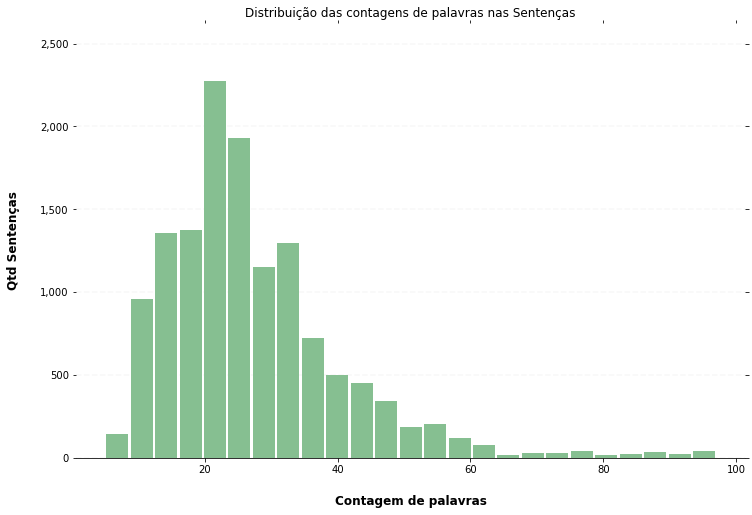

In [192]:
ax = train.hist(column='word_count', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # title
    x.set_title("Distribuição das contagens de palavras nas Sentenças")

    # Set x-axis label
    x.set_xlabel("Contagem de palavras", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Qtd Sentenças", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

### Visualizando a Nuvem de Palavras das sentenças

In [193]:
sentences = train['sentence']
all_sentences = " ".join(s for s in sentences)

In [194]:
wordcloud = WordCloud(background_color='black', width=1600,                            
                      height=800).generate(all_sentences)

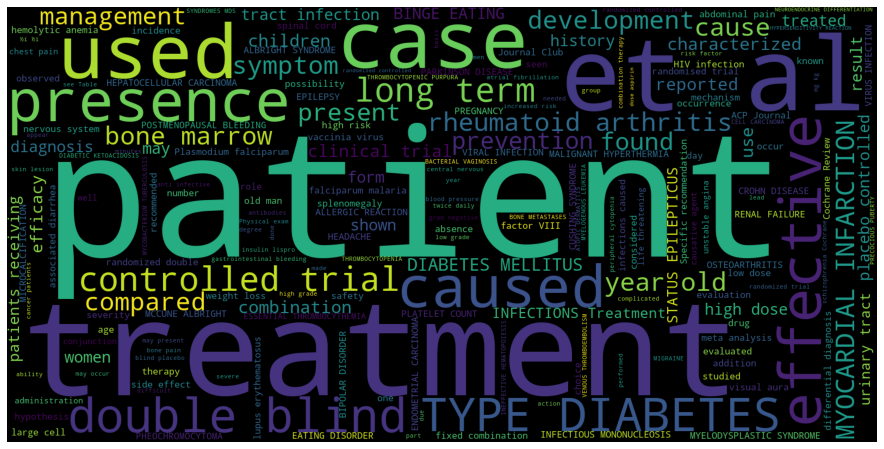

In [195]:
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)  

In [196]:
wordcloud.to_file('PubMed.png',);

### Visualizando a Nuvem de Palavras das relacões entre os termos médicos

In [197]:
directions = train['direction']
all_directions = " ".join(s for s in directions)

In [198]:
wordcloud = WordCloud(background_color='black', width=1600,                            
                      height=800).generate(all_directions)

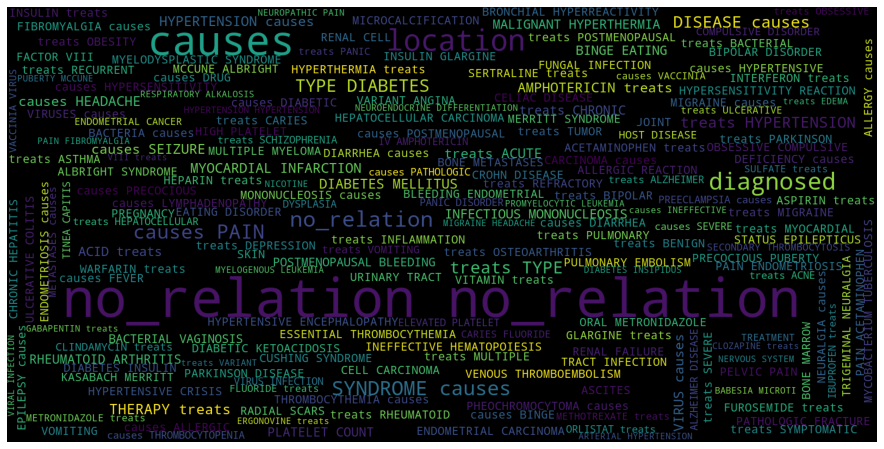

In [199]:
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)  

In [200]:
wordcloud.to_file('Direçao.png',);

Ao explorar essa nuvem de palavras podemos perceber uma grande relevância ao termo "no_relation". Ao avaliar os dados observei que cada sentença foi analisada por sete anotadores diferentes, sendo que alguns registros foram marcados como 'no_relation', neste caso interpretei como não haver relação entre os dois termos médicos.

### Avaliando a distribuição da relação nas anotações entre os termos médicos

In [201]:
import plotly.graph_objs as go
import plotly.offline as py
x1 = train.loc[train['direction'] != 'no_relation', 'relation']
x0 = train.loc[train['direction'] == 'no_relation', 'relation']

trace1 = go.Histogram(
    x=x0, name='Não há Relação',
    opacity=0.75 
)
trace2 = go.Histogram(
    x=x1, name = 'Há Relação',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(title='Distribuição da relação nas anotações entre os termos médicos')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='overlaid histogram')

Podemos perceber através do gráfico que uma grande parte das anotações relacionadas a "causes"(causas) e "treats"(tratamentos), há indicação de não possuir relação entre os termos médicos, será necessário tratar esses registros para entregarmos ao nosso modelo apenas as informações confiáveis. Utilizarei uma medida de confiança para excluir os registros de sentenças onde existe predominância da indicação de não possuir relação entre os termos médicos.

Em nossa fonte de dados existe uma feature denoamina '_trust' (confiança), utilizarei essa informação para criar uma medida de confiança para penalizar os registros onde há indicação de não possuir relação entre os termos médicos, multiplicando o seu valor por -1, depois calculando a média da confiança para cada sentença e depois eliminarei os resgistros onde a média da confiança seja menor ou igaul a zero.

In [202]:
Image(url = '.\Imagens\exemplo.png')

In [203]:
# Considerando o exemplo acima, a sentença com ID 820029 será descartada porque a média da confiança será menor que 0
trust = [0.5694, 0.6696, 0.6845, 0.6643, 0.8548, 0.7063, 0.6905]
pesos = [1, -1, -1, -1, 1, -1, 1]
trusted = np.array(trust).dot(np.array(pesos))
print(trusted/7)

-0.08714285714285715


Para a proposta de trabalho especificada neste mini-projeto tabalharei apenas com as features 'sent_id', 'sentence', 'relation', 'term1' e 'term2', considerando apenas com as anotações relacionadas a tratamentos 'treats' e causas 'causes'.

In [204]:
colunas = ['sent_id','sentence','relation','term1','term2','direction','_trust']
pmd_train  = train[(train['relation'] == 'causes') | (train['relation'] == 'treats')][colunas].copy()
pmd_test   = test[(test['relation'] == 'causes') | (test['relation'] == 'treats')][colunas].copy() 

In [205]:
# Aplicando a penalidade nos registros que possuem indicação de não possuir relação entre os termos médicos
pmd_train['_trust'] = pmd_train.apply(lambda row: row['_trust']*-1 if (row['direction'] == 'no_relation') else row['_trust']*1, axis=1)
pmd_test['_trust'] = pmd_test.apply(lambda row: row['_trust']*-1 if (row['direction'] == 'no_relation') else row['_trust']*1, axis=1)

In [206]:
# Calculando a média da confiança
mean_trust_train = pd.DataFrame(pmd_train.groupby(['sent_id'])['_trust'].mean())
mean_trust_test = pd.DataFrame(pmd_test.groupby(['sent_id'])['_trust'].mean())

In [207]:
pmd_train = pmd_train.merge(mean_trust_train,  left_on='sent_id', right_on='sent_id', how='left')
pmd_test = pmd_test.merge(mean_trust_test,  left_on='sent_id', right_on='sent_id', how='left')

In [208]:
# Descartando os registros com confiança menor ou igaul a zero
pmd_train = pmd_train[(pmd_train['_trust_y'] > 0)]
pmd_test = pmd_test[(pmd_test['_trust_y'] > 0)]

In [209]:
# Removemos as features que não serão utilizadas nos demais processos
del pmd_train['_trust_x']
del pmd_train['direction']
del pmd_test['_trust_x']
del pmd_test['direction']
del pmd_train['_trust_y']
del pmd_test['_trust_y']

In [210]:
pmd_train.head(10)

,sent_id,sentence,relation,term1,term2
0,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
1,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
2,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
3,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
4,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
5,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
6,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
7,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL
8,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL
9,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL


In [211]:
pmd_train.shape

(8321, 5)

In [212]:
pmd_test.head(10)

,sent_id,sentence,relation,term1,term2
7,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
8,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
9,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
10,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
11,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
12,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
13,907481-FS1-2,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,OPIOID OVERDOSE,FLUMAZENIL
14,907512-FS1-2,"Stumpe KO, Haworth D, Hoglund C et al et al. C...",treats,HYPERTENSION,ATENOLOL
15,907512-FS1-2,"Stumpe KO, Haworth D, Hoglund C et al et al. C...",treats,HYPERTENSION,ATENOLOL
16,907512-FS1-2,"Stumpe KO, Haworth D, Hoglund C et al et al. C...",treats,HYPERTENSION,ATENOLOL


In [213]:
pmd_test.shape

(2745, 5)

In [214]:
pmd_train.head(10)

,sent_id,sentence,relation,term1,term2
0,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
1,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
2,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
3,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
4,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
5,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
6,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
7,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL
8,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL
9,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL


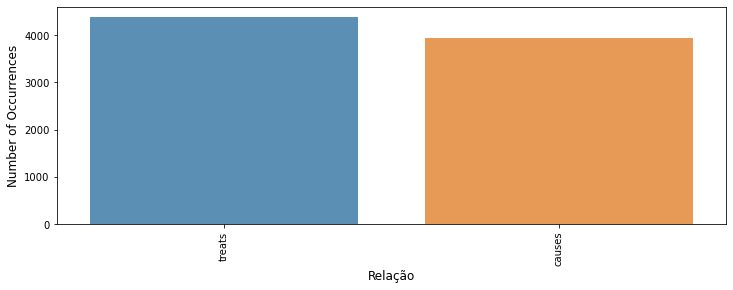

In [215]:
relacao = pmd_train['relation'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(relacao.index, relacao.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relação', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [216]:
print(pmd_train.groupby(['relation'])['relation'].count())

relation
causes    3937
treats    4384
Name: relation, dtype: int64


In [217]:
# Eliminando duplicidades
pmd_train = pmd_train.drop_duplicates().reset_index(drop=True)
pmd_test  = pmd_test.drop_duplicates().reset_index(drop=True)

In [218]:
pmd_train.head(10)

,sent_id,sentence,relation,term1,term2
0,907845-FS1-2,"For treatment of uncomplicated cervical, URETH...",treats,URETHRAL OR RECTAL GONORRHEA,IM CEFTRIAXONE
1,907104-FS1-2,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,EXERCISE INDUCED ASTHMA,SALMETEROL
2,906277-FS1-4,The patients showed the characteristic facies ...,causes,SYNOPHRYS,CORNELIA DE LANGE SYNDROME
3,908224-FS1-2,Dyskinesias occur in the majority of patients ...,treats,PARKINSON'S DISEASE,L DOPA
4,903581-FS1-4,ENDOTOXEMIA was evoked by bolus injection of E...,causes,ESCHERICHIA COLI ENDOTOXIN,ENDOTOXEMIA
5,904608-FS1-4,A possible role of LEU in sensomotor cortex is...,causes,SEIZURES,STATUS EPILEPTICUS
6,907986-FS1-2,Diclofenac sodium was found to be as effective...,treats,POSTOPERATIVE INFLAMMATION,PREDNISOLONE ACETATE
7,902961-FS1-4,This case demonstrates a typical presentation ...,causes,HYPERTENSION,PHEOCHROMOCYTOMA
8,908192-FS1-2,Patients with otitis media received approximat...,treats,PHARYNGITIS,CEFACLOR
9,908133-FS1-2,The objective of this study is to perform a co...,treats,RHEUMATOID ARTHRITIS,ADALIMUMAB


In [219]:
pmd_train.shape[0]

1187

In [220]:
pmd_test.shape[0]

395

## Lendo os dados com pré-processamento utilizando a biblioteca NLTK

Agora vamos efetuar a leitura dos dados, converter o texto para letras minúscula, remoção de contrações e depois converter em tokens usando a biblioteca nltk. Temos duas funções `read_data` para montar os dados de treino e `read_test_data` para montar os dados de teste.

In [221]:
import re

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                    "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                    "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                    "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                    "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                    "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
                    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                    "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
                    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
                    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
                    "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [222]:
def read_data(filename):
    """
    Extrai as sentenças dos dados de treino e efetua o pré-processamento usando a biblioteca nltk python
    
    """
    stop_words = set(stopwords.words('english'))
    data  = [[],[]] 
    term1 = [[],[]]
    term2 = [[],[]]
    train_data = {}
    for i in range(filename.shape[0]):
        text_string = filename[filename.columns[1]][i]
        text_term1  = filename[filename.columns[3]][i]
        text_term2  = filename[filename.columns[4]][i]
        text_string = text_string.lower()
        text_term1  = text_term1.lower()
        text_term2  = text_term2.lower()
        """ Limpeza do texto"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string)
        """tokenize"""
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        text_term1  = tokenizer.tokenize(text_term1)
        text_term2  = tokenizer.tokenize(text_term2)
        # Atribui a classe aos arquivos
        """ Elimina Sporwords """
        text_string  = [w for w in text_string if not w in stop_words]
        text_term1   = [w for w in text_term1 if not w in stop_words]
        text_term2   = [w for w in text_term2 if not w in stop_words]
        """ Atribui a relação a sentença """
        data[0].append(text_string)
        data[1].append(filename[filename.columns[2]][i])
        """ Atribui a relação ao termo 1 """
        term1[0].append(text_term1)        
        term1[1].append(filename[filename.columns[2]][i])
        """ Atribui a relação ao termo 2 """
        term2[0].append(text_term2)
        term2[1].append(filename[filename.columns[2]][i]) 
        
        train_data[filename[filename.columns[2]][i]+'-'+filename[filename.columns[0]][i]] = text_string
        print('\tConcluída a leitura de dados para a Relação: ',filename[filename.columns[2]][i]) 
               
    return data, term1, term2, train_data

def read_test_data(filename):
    """
    Extrai as sentenças dos dados de teste e efetua o pré-processamento usando a biblioteca nltk python
    """
    test_data = {}
    for i in range(filename.shape[0]):
        text_string = filename[filename.columns[1]][i]
        text_string = text_string.lower()
        """ Limpeza do texto"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string) 
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Atribui a classe aos arquivos
        """ Atribui a relação ao documento """
        test_data[filename[filename.columns[2]][i]+'-'+filename[filename.columns[0]][i]] = text_string
        print('\tConcluída a leitura de dados para a Relação: ',filename[filename.columns[2]][i]) 
               
    return test_data

print('Processando dados de treinamento...\n')
words, terms1, terms2, train_words = read_data(pmd_train)

print('\nProcessando dados de teste...\n')

test_words = read_test_data(pmd_test)


Processando dados de treinamento...

	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:

	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dados para a Relação:  causes
	Concluída a leitura de dado

	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dados para a Relação:  treats
	Concluída a leitura de dado

## Construindo os Dicionários
Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]

Também introduzimos um token especial adicional chamado `UNK` para indicar que palavras raras são muito raras para serem usadas, porém garantirei que as palavras que constam nos termos 1 e 2 estejam presentes em nosso dicionário, porque alguns termos médicos são realmente raros e se eleinarmos podemos comprometer o desenpenho do modelo.

In [223]:
vocabulary_size = 5500
term1_size = 2500
term2_size = 2500
Words  = []
Terms1 = []
Terms2 = []
def build_dataset(words, terms1, terms2):
    for word in words[0]:
        Words.extend(word)  
    for term in terms1[0]:
        Terms1.extend(term)  
    for term in terms2[0]:
        Terms2.extend(term)          
    count = [['UNK', -1]]
    count.extend(collections.Counter(Words).most_common(vocabulary_size - 1))
    countT1 = []
    countT1.extend(collections.Counter(Terms1).most_common(term1_size - 1))
    countT2 = []
    countT2.extend(collections.Counter(Terms2).most_common(term2_size - 1))    
    # Dicionário das sentenças
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # Dicionário do Termo 1
    dictT1 = dict()
    for terms1, _ in countT1:
        dictT1[word] = len(dictT1)
    # Dicionário do Termo 2
    dictT2 = dict()
    for terms2, _ in countT2:
        dictT2[word] = len(dictT2)        
    data = list()
    unk_count = 0
    for word in Words:
        if  word in dictionary or word in dictT1 or word in dictT2:            
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']            
            unk_count = unk_count + 1
            
        data.append(word)

    count[0][1] = unk_count
    assert len(dictionary) == vocabulary_size

    return data, count, dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    '''
    Aqui usamos essa função para converter strings de palavras em IDs com um determinado dicionário
    '''
    data = list()
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
        data.append(word)
    return data

# Processando dados de treino
data, count, dictionary = build_dataset(words, terms1, terms2)

train_data = {}

for k,v in train_words.items():
    print('Construindo o dataset de treino para o documento ', k)
    train_data[k] = build_dataset_with_existing_dictionary(train_words[k],dictionary)

# Processando dados de teste

test_data = {}

for k,v in test_words.items():
    print('Construindo o dataset de teste para o documento ', k)
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)
    
print('\nPalavras mais comuns (+UNK)', count[:5])
print('\nAmostra de dados', data[:10])
print('\nChaves: ', test_data.keys())
print('\nItems: ', test_data.items())

# Removemos para liberar memória no computador. Não precisamos mais desses objetos.
#del words  
del data
del count
del dictionary

Construindo o dataset de treino para o documento  treats-907845-FS1-2
Construindo o dataset de treino para o documento  treats-907104-FS1-2
Construindo o dataset de treino para o documento  causes-906277-FS1-4
Construindo o dataset de treino para o documento  treats-908224-FS1-2
Construindo o dataset de treino para o documento  causes-903581-FS1-4
Construindo o dataset de treino para o documento  causes-904608-FS1-4
Construindo o dataset de treino para o documento  treats-907986-FS1-2
Construindo o dataset de treino para o documento  causes-902961-FS1-4
Construindo o dataset de treino para o documento  treats-908192-FS1-2
Construindo o dataset de treino para o documento  treats-908133-FS1-2
Construindo o dataset de treino para o documento  treats-908261-FS1-2
Construindo o dataset de treino para o documento  treats-908293-FS1-2
Construindo o dataset de treino para o documento  treats-907917-FS1-2
Construindo o dataset de treino para o documento  treats-907215-FS1-2
Construindo o datase

Construindo o dataset de treino para o documento  treats-902788-FS1-2
Construindo o dataset de treino para o documento  treats-908181-FS1-2
Construindo o dataset de treino para o documento  treats-902646-FS1-2
Construindo o dataset de treino para o documento  causes-906439-FS1-4
Construindo o dataset de treino para o documento  treats-906990-FS1-2
Construindo o dataset de treino para o documento  treats-906708-FS1-2
Construindo o dataset de treino para o documento  causes-907661-FS1-4
Construindo o dataset de treino para o documento  treats-907591-FS1-2
Construindo o dataset de treino para o documento  causes-902703-FS1-4
Construindo o dataset de treino para o documento  causes-904788-FS1-4
Construindo o dataset de treino para o documento  treats-907990-FS1-2
Construindo o dataset de treino para o documento  causes-900407-FS1-4
Construindo o dataset de treino para o documento  treats-907661-FS1-2
Construindo o dataset de treino para o documento  causes-904857-FS1-4
Construindo o datase

Construindo o dataset de treino para o documento  causes-902970-FS1-4
Construindo o dataset de treino para o documento  treats-907492-FS1-2
Construindo o dataset de treino para o documento  causes-901839-FS1-4
Construindo o dataset de treino para o documento  causes-902718-FS1-4
Construindo o dataset de treino para o documento  causes-903981-FS1-4
Construindo o dataset de treino para o documento  treats-908308-FS1-2
Construindo o dataset de treino para o documento  causes-900460-FS1-4
Construindo o dataset de treino para o documento  causes-902927-FS1-4
Construindo o dataset de treino para o documento  treats-908250-FS1-2
Construindo o dataset de treino para o documento  causes-903889-FS1-4
Construindo o dataset de treino para o documento  causes-902782-FS1-4
Construindo o dataset de treino para o documento  treats-908255-FS1-2
Construindo o dataset de treino para o documento  treats-907810-FS1-2
Construindo o dataset de treino para o documento  causes-904831-FS1-4
Construindo o datase

Construindo o dataset de treino para o documento  treats-907359-FS1-2
Construindo o dataset de treino para o documento  causes-904940-FS1-4
Construindo o dataset de treino para o documento  treats-908272-FS1-2
Construindo o dataset de treino para o documento  causes-906352-FS1-4
Construindo o dataset de treino para o documento  causes-906228-FS1-4
Construindo o dataset de treino para o documento  treats-907826-FS1-2
Construindo o dataset de treino para o documento  treats-908045-FS1-2
Construindo o dataset de treino para o documento  treats-907579-FS1-2
Construindo o dataset de treino para o documento  treats-907897-FS1-2
Construindo o dataset de treino para o documento  causes-903897-FS1-4
Construindo o dataset de treino para o documento  causes-906470-FS1-4
Construindo o dataset de treino para o documento  causes-903835-FS1-4
Construindo o dataset de treino para o documento  causes-903698-FS1-4
Construindo o dataset de treino para o documento  causes-902348-FS1-4
Construindo o datase

Construindo o dataset de treino para o documento  causes-812425-FS1-4
Construindo o dataset de treino para o documento  causes-814803-FS1-4
Construindo o dataset de treino para o documento  causes-811980-FS1-4
Construindo o dataset de treino para o documento  causes-812157-FS1-4
Construindo o dataset de treino para o documento  causes-814385-FS1-4
Construindo o dataset de treino para o documento  causes-812164-FS1-4
Construindo o dataset de treino para o documento  causes-811350-FS1-4
Construindo o dataset de treino para o documento  causes-813771-FS1-4
Construindo o dataset de treino para o documento  causes-813896-FS1-4
Construindo o dataset de treino para o documento  causes-810024-FS1-4
Construindo o dataset de treino para o documento  causes-803219-FS1-4
Construindo o dataset de treino para o documento  causes-813937-FS1-4
Construindo o dataset de treino para o documento  causes-812728-FS1-4
Construindo o dataset de treino para o documento  causes-812692-FS1-4
Construindo o datase

Construindo o dataset de treino para o documento  causes-803246-FS1-4
Construindo o dataset de treino para o documento  causes-812836-FS1-4
Construindo o dataset de treino para o documento  causes-814140-FS1-4
Construindo o dataset de treino para o documento  causes-813772-FS1-4
Construindo o dataset de treino para o documento  causes-811277-FS1-4
Construindo o dataset de treino para o documento  causes-810469-FS1-4
Construindo o dataset de treino para o documento  causes-814472-FS1-4
Construindo o dataset de treino para o documento  causes-810193-FS1-4
Construindo o dataset de treino para o documento  causes-810593-FS1-4
Construindo o dataset de treino para o documento  causes-810435-FS1-4
Construindo o dataset de treino para o documento  causes-811525-FS1-4
Construindo o dataset de treino para o documento  causes-812857-FS1-4
Construindo o dataset de treino para o documento  causes-803279-FS1-4
Construindo o dataset de treino para o documento  causes-814053-FS1-4
Construindo o datase

Construindo o dataset de treino para o documento  causes-814039-FS1-4
Construindo o dataset de treino para o documento  causes-811127-FS1-4
Construindo o dataset de treino para o documento  causes-812932-FS1-4
Construindo o dataset de treino para o documento  causes-812383-FS1-4
Construindo o dataset de treino para o documento  causes-810886-FS1-4
Construindo o dataset de treino para o documento  causes-810843-FS1-4
Construindo o dataset de treino para o documento  causes-814691-FS1-4
Construindo o dataset de treino para o documento  causes-813004-FS1-4
Construindo o dataset de treino para o documento  causes-810012-FS1-4
Construindo o dataset de treino para o documento  causes-800258-FS1-4
Construindo o dataset de treino para o documento  causes-803170-FS1-4
Construindo o dataset de treino para o documento  causes-810180-FS1-4
Construindo o dataset de treino para o documento  causes-814860-FS1-4
Construindo o dataset de treino para o documento  causes-810225-FS1-4
Construindo o datase

Construindo o dataset de treino para o documento  treats-215430
Construindo o dataset de treino para o documento  treats-803991
Construindo o dataset de treino para o documento  treats-804694
Construindo o dataset de treino para o documento  treats-800730
Construindo o dataset de treino para o documento  treats-213537
Construindo o dataset de treino para o documento  treats-804373
Construindo o dataset de treino para o documento  treats-811813
Construindo o dataset de treino para o documento  treats-907526
Construindo o dataset de treino para o documento  treats-803651
Construindo o dataset de treino para o documento  treats-908309
Construindo o dataset de treino para o documento  treats-803830
Construindo o dataset de treino para o documento  treats-213913
Construindo o dataset de treino para o documento  treats-906530
Construindo o dataset de treino para o documento  treats-220499
Construindo o dataset de treino para o documento  treats-803551
Construindo o dataset de treino para o d

Construindo o dataset de treino para o documento  treats-205509
Construindo o dataset de treino para o documento  treats-800316
Construindo o dataset de treino para o documento  treats-908348
Construindo o dataset de treino para o documento  treats-804836
Construindo o dataset de treino para o documento  treats-206856
Construindo o dataset de treino para o documento  treats-223212
Construindo o dataset de treino para o documento  treats-206397
Construindo o dataset de treino para o documento  treats-211605
Construindo o dataset de treino para o documento  treats-800435
Construindo o dataset de treino para o documento  treats-908250
Construindo o dataset de treino para o documento  treats-800082
Construindo o dataset de treino para o documento  treats-804645
Construindo o dataset de treino para o documento  treats-804400
Construindo o dataset de treino para o documento  treats-907500
Construindo o dataset de treino para o documento  treats-908204
Construindo o dataset de treino para o d

Construindo o dataset de treino para o documento  treats-800759
Construindo o dataset de treino para o documento  treats-907711
Construindo o dataset de treino para o documento  treats-800068
Construindo o dataset de treino para o documento  treats-908219
Construindo o dataset de treino para o documento  treats-908308
Construindo o dataset de treino para o documento  treats-907893
Construindo o dataset de treino para o documento  treats-219713
Construindo o dataset de treino para o documento  treats-221904
Construindo o dataset de treino para o documento  treats-209373
Construindo o dataset de treino para o documento  treats-907011
Construindo o dataset de treino para o documento  treats-907148
Construindo o dataset de treino para o documento  treats-800218
Construindo o dataset de treino para o documento  treats-210603
Construindo o dataset de treino para o documento  treats-214862
Construindo o dataset de treino para o documento  treats-907536
Construindo o dataset de treino para o d

Construindo o dataset de teste para o documento  treats-907332-FS1-2
Construindo o dataset de teste para o documento  treats-908168-FS1-2
Construindo o dataset de teste para o documento  treats-902852-FS1-2
Construindo o dataset de teste para o documento  treats-907636-FS1-2
Construindo o dataset de teste para o documento  causes-901889-FS1-4
Construindo o dataset de teste para o documento  causes-904571-FS1-4
Construindo o dataset de teste para o documento  causes-903926-FS1-4
Construindo o dataset de teste para o documento  causes-906249-FS1-4
Construindo o dataset de teste para o documento  causes-903749-FS1-4
Construindo o dataset de teste para o documento  causes-902898-FS1-4
Construindo o dataset de teste para o documento  treats-907754-FS1-2
Construindo o dataset de teste para o documento  treats-908084-FS1-2
Construindo o dataset de teste para o documento  treats-902920-FS1-2
Construindo o dataset de teste para o documento  treats-907872-FS1-2
Construindo o dataset de teste par

Construindo o dataset de teste para o documento  treats-907847-FS1-2
Construindo o dataset de teste para o documento  treats-907915-FS1-2
Construindo o dataset de teste para o documento  treats-906931-FS1-2
Construindo o dataset de teste para o documento  causes-906382-FS1-4
Construindo o dataset de teste para o documento  treats-907952-FS1-2
Construindo o dataset de teste para o documento  treats-907612-FS1-2
Construindo o dataset de teste para o documento  treats-908313-FS1-2
Construindo o dataset de teste para o documento  causes-903785-FS1-4
Construindo o dataset de teste para o documento  treats-907907-FS1-2
Construindo o dataset de teste para o documento  causes-810907-FS1-4
Construindo o dataset de teste para o documento  causes-813253-FS1-4
Construindo o dataset de teste para o documento  causes-813536-FS1-4
Construindo o dataset de teste para o documento  causes-803342-FS1-4
Construindo o dataset de teste para o documento  causes-811897-FS1-4
Construindo o dataset de teste par

Construindo o dataset de teste para o documento  treats-907439
Construindo o dataset de teste para o documento  treats-216777
Construindo o dataset de teste para o documento  treats-210527
Construindo o dataset de teste para o documento  treats-908313
Construindo o dataset de teste para o documento  treats-207613
Construindo o dataset de teste para o documento  treats-208517
Construindo o dataset de teste para o documento  treats-803533
Construindo o dataset de teste para o documento  treats-907922
Construindo o dataset de teste para o documento  treats-803399
Construindo o dataset de teste para o documento  treats-221085
Construindo o dataset de teste para o documento  treats-213851
Construindo o dataset de teste para o documento  treats-803565
Construindo o dataset de teste para o documento  treats-206509
Construindo o dataset de teste para o documento  treats-804799
Construindo o dataset de teste para o documento  treats-815154
Construindo o dataset de teste para o documento  treats

Palavras mais comuns (+UNK) [['UNK', 427], ('patients', 321), ('treatment', 261), ('disease', 122), ('pain', 110)]

Amostra de dados ['treatment', 'uncomplicated', 'cervical', 'urethral', 'rectal', 'gonorrhea', 'cdc', 'others', 'recommend', 'im']



Chaves:  dict_keys(['treats-907481-FS1-2', 'treats-907512-FS1-2', 'treats-907946-FS1-2', 'causes-902598-FS1-4', 'causes-902711-FS1-4', 'causes-903801-FS1-4', 'treats-907886-FS1-2', 'causes-900222-FS1-4', 'causes-900463-FS1-4', 'treats-906015-FS1-2', 'causes-906010-FS1-4', 'causes-906702-FS1-4', 'causes-903797-FS1-4', 'causes-904798-FS1-4', 'treats-908038-FS1-2', 'causes-908082-FS1-4', 'causes-905080-FS1-4', 'treats-907970-FS1-2', 'treats-908088-FS1-2', 'causes-904858-FS1-4', 'causes-902706-FS1-4', 'causes-901923-FS1-4', 'treats-907106-FS1-2', 'causes-903786-FS1-4', 'causes-900317-FS1-4', 'treats-906772-FS1-2', 'causes-900348-FS1-4', 'causes-903672-FS1-4', 'treats-907332-FS1-2', 'treats-908168-FS1-2', 'treats-902852-FS1-2', 'treats-907636-FS1-2', 'causes-901889-FS1-4', 'causes-904571-FS1-4', 'causes-903926-FS1-4', 'causes-906249-FS1-4', 'causes-903749-FS1-4', 'causes-902898-FS1-4', 'treats-907754-FS1-2', 'treats-908084-FS1-2', 'treats-902920-FS1-2', 'treats-907872-FS1-2', 'treats-907972

Items:  dict_items([('treats-907481-FS1-2', ['clonidine', 'oxymetazoline', 'tetrahydozoline', 'brimonidine', 'tizanidine', 'barbiturates', 'opioids', 'benzodiazepines', 'give', 'naloxone', 'for', 'suspected', 'opioid', 'overdose', 'consider', 'flumazenil', 'for', 'benzodiazepine', 'overdose', 'cholinergic', 'pinpoint', 'pupils', 'variable', 'hr', 'sweaty', 'skin', 'abdominal', 'cramps', 'and', 'diarrhea', 'organophosphate', 'and', 'carbamate', 'insecticides', 'chemical', 'warfare', 'nerve', 'agents', 'give', 'atropine', 'and', 'pralidoxime', 'obtain', 'measurements', 'of', 'serum', 'and', 'rbc', 'cholinesterase', 'activity', 'anticholinergic', 'agitation', 'delirium', 'dilated', 'pupils', 'tachycardia', 'decreased', 'peristalsis', 'dry', 'flushed', 'skin', 'atropine', 'and', 'related', 'drugs', 'antihistamines', 'carbamazepine', 'phenothiazines', 'tricyclic', 'antidepressants', 'obtain', 'immediate', 'ecg']), ('treats-907512-FS1-2', ['stumpe', 'ko', 'haworth', 'd', 'hoglund', 'c', 'et'

## Preparação dos dados para criação do vocabulário no doc2vec

In [224]:
# Converte de Dicionário para lista
data_train = [ [k,v] for k, v in train_data.items() ]
data_train = np.array(data_train)
data_test = [ [k,v] for k, v in test_data.items() ]
data_test = np.array(data_test)

In [225]:
# função para Identificar as classes dos documentos e preparando os dados para o algoritimo
def prepara_dados(data):
    datax = [[],[]]
    for x in range(data.shape[0]):
        s = data[x][0]
        s = s.split("-")
        datax[0].append(s[0])
        datax[1].append(data[x][1])                
    return datax

data_train = prepara_dados(data_train)
data_test = prepara_dados(data_test)

In [226]:
def label_sentences(corpus, topics):
    """
    A implementação do Doc2Vec da Gensim exige que cada documento / parágrafo tenha um rótulo associado a ele.
    Fiz isso usando o método TaggedDocument, etiquetando com a própria classe do documento.
    """
   
    labeled = []
    tags = np.unique(topics, return_counts=False)
    for i, v in enumerate(corpus):
        label = [s for s in tags if topics[i] in s]
        doc =  " ".join(str(x) for x in v)
        labeled.append(TaggedDocument(doc.split(), label))
    return labeled
X_train = label_sentences(np.array(data_train[1]), data_train[0])
X_test  = label_sentences(np.array(data_test[1]), data_test[0])

In [227]:
print(X_test[:1])

[TaggedDocument(words=['clonidine', 'oxymetazoline', 'tetrahydozoline', 'brimonidine', 'tizanidine', 'barbiturates', 'opioids', 'benzodiazepines', 'give', 'naloxone', 'for', 'suspected', 'opioid', 'overdose', 'consider', 'flumazenil', 'for', 'benzodiazepine', 'overdose', 'cholinergic', 'pinpoint', 'pupils', 'variable', 'hr', 'sweaty', 'skin', 'abdominal', 'cramps', 'and', 'diarrhea', 'organophosphate', 'and', 'carbamate', 'insecticides', 'chemical', 'warfare', 'nerve', 'agents', 'give', 'atropine', 'and', 'pralidoxime', 'obtain', 'measurements', 'of', 'serum', 'and', 'rbc', 'cholinesterase', 'activity', 'anticholinergic', 'agitation', 'delirium', 'dilated', 'pupils', 'tachycardia', 'decreased', 'peristalsis', 'dry', 'flushed', 'skin', 'atropine', 'and', 'related', 'drugs', 'antihistamines', 'carbamazepine', 'phenothiazines', 'tricyclic', 'antidepressants', 'obtain', 'immediate', 'ecg'], tags=['treats'])]


In [228]:
len(X_train)

1178

In [229]:
len(X_test)

395

## Modelos de Treinamento e Avaliação doc2Vec


Doc2vec é um algoritmo não supervisionado para gerar vetores para frases, parágrafos ou documentos (Representações distribuídas de sentenças e documento). Trata-se de um conceito que foi apresentado em 2014 por Le & Mikilov, veja neste [artigo](https://arxiv.org/abs/1405.4053). Este algoritmo é uma adaptação do word2vec, sendo que os vetores gerados pelo doc2vec podem ser usados para tarefas como encontrar semelhanças entre sentenças , parágrafos ou documentos.

Um vetor de documento é uma representação abstrata de comprimento variável do significado contextual de um determinado tipo de documento. Assim como um vetor de palavras, é o produto do processo de treinamento para uma rede neural, onde a entrada é tipicamente um termo one-hot encoded codificado a partir do vocabulário do modelo e a saída é uma distribuição de probabilidade para palavras na próxima janela de contexto. 

Primeiramente instanciamos um modelo doc2vec - Distributed Bag of Words (DBOW). Na arquitetura word2vec, nós temos os algoritmos  “continuous bag of words” (CBOW) e “skip-gram” (SG), já na arquitetura doc2vec, os algoritmos correspondentes são “distributed memory” (DM) e “distributed bag of words” (DBOW).

O DBOW é o modelo doc2vec análogo ao modelo Skip-gram do word2vec. Os vetores de parágrafos são obtidos pelo treinamento de uma rede neural na tarefa de prever uma distribuição de probabilidade de palavras em um parágrafo, dada uma palavra aleatoriamente amostrada do parágrafo.

In [230]:
Image(url = '.\Imagens\Doc2Vec.png')

In [231]:
# Instanciando um modelo Doc2Vec com um vetor de 128 palavras
max_epochs = 50
vec_size = 128
alpha = 0.1

model_dbow = Doc2Vec(dm=0, vector_size=vec_size, window=10, seed=42, negative=5, cbow_mean=1, min_count=2, alpha=alpha, min_alpha=0.005)
model_dbow.build_vocab([x for x in tqdm(X_train)])


# Alicando 50 iterações sobre o corpus de treinamento.

for epoch in range(max_epochs):
    model_dbow.train(utils.shuffle([x for x in tqdm(X_train)]), total_examples=len(X_train), epochs=epoch)
    model_dbow.alpha -= 0.001
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1178/1178 [00:00<00:00, 1181183.39it/s]


## Construindo os Vetores de Recurso para o Classificador

In [232]:
%%time

# Aplicando o modelo aos dados de treino

train_targets, train_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=50)) for doc in X_train])

Wall time: 2.39 s


In [233]:
%%time

# Aplicando o modelo aos dados de teste

test_targets, test_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=50)) for doc in X_test])

Wall time: 801 ms


## Treinando o Classificador de Regressão Logística.

In [234]:
# Aplicando de Regressão Logistica
logreg = LogisticRegression(n_jobs=1, C=0.01, solver = 'lbfgs', penalty = 'l2', max_iter=10000)
logreg.fit(train_regressors, train_targets)
y_pred = logreg.predict(test_regressors)
y_score = logreg.predict_proba(test_regressors)

## Avaliando a performance do modelo

In [235]:
relations = np.unique(test_targets)

In [236]:
print('accuracy %s' % accuracy_score(y_pred, test_targets))
print(classification_report(test_targets, y_pred,target_names=relations))

accuracy 0.9012658227848102
              precision    recall  f1-score   support

      causes       0.90      0.88      0.89       181
      treats       0.90      0.92      0.91       214

    accuracy                           0.90       395
   macro avg       0.90      0.90      0.90       395
weighted avg       0.90      0.90      0.90       395



In [237]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(relations))
    target_names = relations
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [238]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=relations)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    return cm

accuracy 0.9012658227848102
confusion matrix
 [[160  21]
 [ 18 196]]
(row=expected, col=predicted)


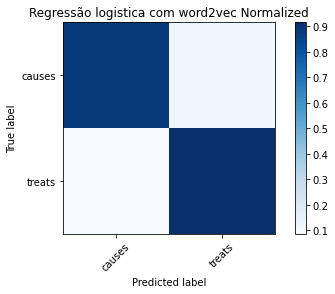

In [239]:
cm = evaluate_prediction(y_pred, np.array(test_targets), "Regressão logistica com word2vec")

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

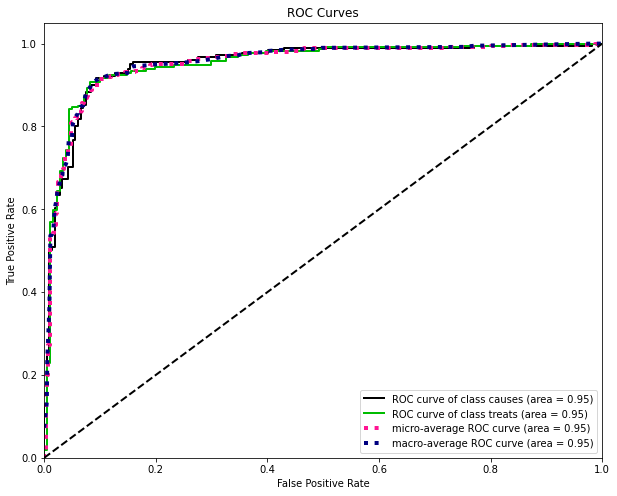

In [240]:
import scikitplot as skplt
skplt.metrics.plot_roc(test_targets, y_score, figsize=(10, 8))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

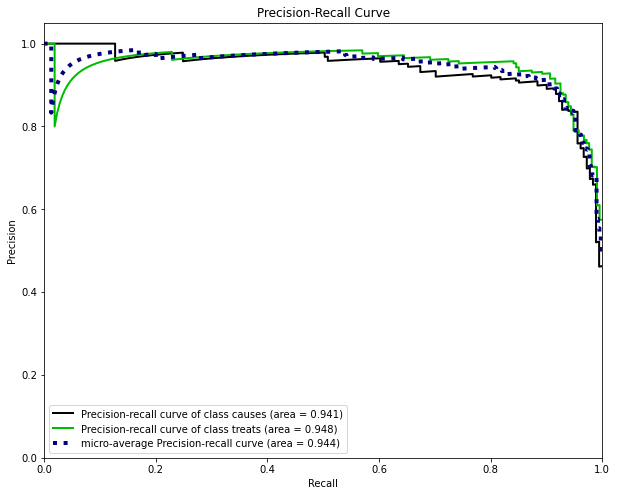

In [241]:
skplt.metrics.plot_precision_recall(test_targets, y_score, figsize=(10, 8))

Os graficos de Curva ROC e Precisão-Recall demostram uma grande capacidade do modelo rotular todas as instâncias corretamente.

## Cohen Kappa

O Cohen kappa é uma métrica frequentemente usada para avaliar a concordância entre dois avaliadores. Também pode ser usado para avaliar o desempenho de um modelo de classificação, como muitas outras métricas de avaliação, o Cohen kappa é calculado com base na matriz de confusão.

Landis e Koch (1977) classificam os diferentes níveis de concordância
(ou reprodutibilidade), o Kappa varia de 0 a 1, conforme mostra tabela abaixo:


      Valores de Kappa    Interpretação
           < 0            Ausência de concordância
         0 - 0.20         Concordância mínima
      0.21 - 0.40         Concordância razoável
      0.41 - 0.60         Concordância moderada
      0.61 - 0.80         Concordância substancial
      0.81 - 1.00         Concordância quase perfeita

A estatística kappa é freqüentemente usada como uma medida de confiabilidade entre dois avaliadores humanos. No aprendizado de máquina supervisionado, um "avaliador" reflete a verdade básica, ou seja, os valores reais de cada instância a ser classificada, obtidos a partir de dados rotulados, e o outro "avaliador" é o classificador de aprendizado de máquina usado para realizar a classificação.

Considerando os dados de nosso modelo temos:

     accuracy 0.8936708860759494

     confusion matrix
     causes  |158 |  23|
     treats  |17  | 197|

Então temos 175 (158 + 17 = 175) ocorrências foram classificadas como 'causes' de acordo com o vedadeiro valor e 181 (158 + 23 = 181) ocorrências foram classificadas como 'causes' pelo classificador. Isso resulta num valor de 80,18 (175 * 181/395 = 80,18). O mesmo cálculo deve ser feito para a segunda classe e assim sucessivamente se houver mais de duas classes. Então 220 (197 + 23 = 220) instâncias foram classificadas como 'treats' de acordo com o verdadeiro valor, e 214 (17 + 197 = 214) instâncias foram classificadas como 'treats' pelo classificador. Isso resulta em um valor de 119,19 (220 * 214/395 = 119,19). A etapa final é somar todos esses valores e, finalmente, dividir novamente pelo número total de instâncias, resultando em uma precisão esperada de 0,505 (80,18 + 119,19) / 395 = 0,505). A Precisão esperada é de 50%, como sempre será o caso quando um "avaliador" classificar cada classe com a mesma frequência em uma classificação binária.

A estatística kappa pode então ser calculada usando a precisão observada ( 0,898 ) e a precisão esperada ( 0,505 ) e a fórmula:

Kappa = (observed accuracy - expected accuracy)/(1 - expected accuracy) 

Portanto, em nosso caso, a estatística kappa é igual a: (0,898 - 0,505) / (1 - 0,505) = 0,79.


In [242]:
# Aplicando o Estatística Kappa
cohen_kappa = cohen_kappa_score(test_targets, y_pred)

In [243]:
cohen_kappa 

0.8008892450464656

### Conclusão 
De acordo o a tabela, nosso modelo obteve um score Kappa de 0,79, isso significa que há uma concordância substancial entre a classificação realizada pelos anotadores humanos e a classificação realizada pelo modelo, comprovando que o modelo atingiu uma execelnete capacidade de classificar corretamente a relação entre os termos médicos, demonstrando o grande potencial do PLN em extrair informações de dados não estruturados.

## Referencias

[Curso de Processamento de Linguagem Natural e Reconhecimento de Voz da Formação Inteligência Artificial - Datascienceacademy](https://www.datascienceacademy.com.br)

[appen - Medical Information Extraction](https://appen.com/datasets/medical-sentence-summary-and-relation-extraction/)

[Gemsin](https://radimrehurek.com/gensim/models/keyedvectors.html)

[Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

[Distributed Representations of Sentences and Documents](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)

[A gentle introduction to Doc2Vec](https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)

[Gensim Doc2Vec Tutorial on the IMDB Sentiment Dataset](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb)

[Document classification with word embeddings tutorial](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb)

[Extracting Clinical Relationships from Patient Narratives](https://www.aclweb.org/anthology/W08-0602.pdf)

[Clinical information extraction applications: A literature review](https://www.sciencedirect.com/science/article/pii/S1532046417302563#b0035)

[Using Deep Learning for End to End Multiclass Text Classification](https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/)

[Training a Machine Learning Classifier for Relation Extraction from Medical Literature](https://devblogs.microsoft.com/cse/2016/09/13/training-a-classifier-for-relation-extraction-from-medical-literature/#Reuse)

[Extracting Information from Text](https://www.nltk.org/book/ch07.html)
